# Data Explore and Cleaning
- CSE627 Project 1: Shelter Animal Outcome, details of this contest please refer to [this](https://www.kaggle.com/c/shelter-animal-outcomes) link.
- By Xian Liu & Matth Spinelli

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, merge

%pylab inline
np.random.seed(127)
sns.set_palette("hls", 5)

Populating the interactive namespace from numpy and matplotlib


In [4]:
animals = pd.read_csv("train.csv.gz", compression='gzip')
animals.info(verbose=True, null_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtypes: object(10)
memory usage: 2.0+ MB


### How OutcomeType affected by AnimalType and SexuponOutcome
Our target column is "OutcomeType". To warm up, we are interested to see how the "AnimalType" and "SexuponOutcome" attributes affect an animals outcome.

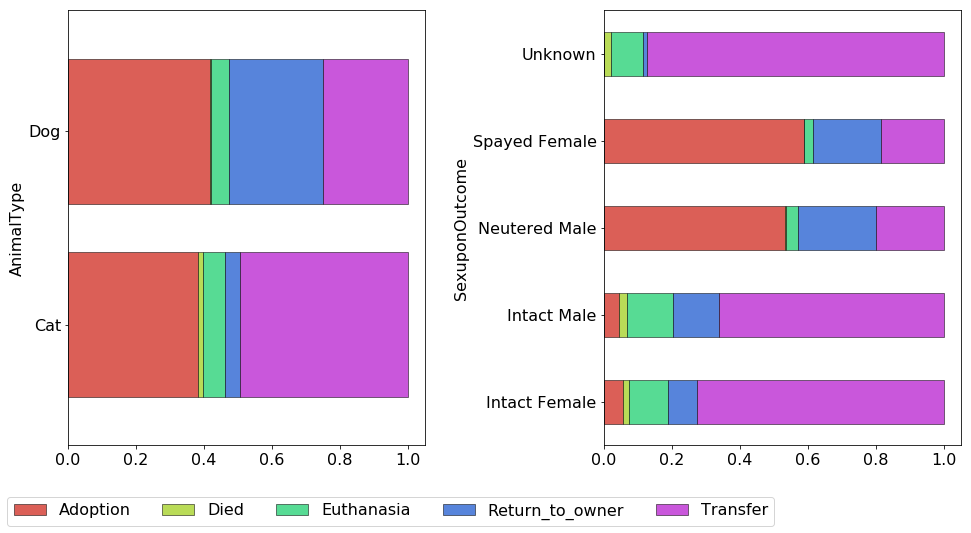

In [5]:
f, axs = plt.subplots(ncols=2)

axs[0].yaxis.label.set_size(16)
axs[1].yaxis.label.set_size(16)

f.set_size_inches(16, 8)
plt.subplots_adjust(wspace=.5)

(animals
 .groupby("AnimalType")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, ax=axs[0], width = 0.75, 
       fontsize=16, edgecolor='k', linewidth=0.5)
 .legend(fontsize=16, ncol=5, bbox_to_anchor=(2, -.1))
)

(animals
 .groupby("SexuponOutcome")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, ax=axs[1], fontsize=16, 
       edgecolor='k', linewidth=0.5, legend=False)
);

We have several findings here:
* Both dogs and cats has a low "Euthanasia" and "Died" rate, good news.
* Dogs are significantly more likely to be "Return_to_owner" than cats.
* Cats has a higher "Transfer" rate
* Intact + Unknown animals are more likely to be transfered. If we want to increase adoption rate, we should get animals neutered.
* "Unknown" group never gets adopted.

So far we don't know what other information we can draw from these features, we'll leave them as is.

In [6]:
# categorical feature "type"
typedict = {"Dog": 0, "Cat":1}
animals["type"] = animals["AnimalType"].map(typedict)

## Clean-up NULL values

First, we want to know the columns that has `np.nan` values and the number of `np.nan`s

In [7]:
for att in animals.columns:
    nums = animals[att].isnull().value_counts().as_matrix()
    if (len(nums) != 1):
        print "Feature \"{}\" has {} missing values".format(att, nums[-1])

Feature "Name" has 7691 missing values
Feature "OutcomeSubtype" has 13117 missing values
Feature "SexuponOutcome" has 1 missing values
Feature "AgeuponOutcome" has 18 missing values


### Name NULL values

Name might not seem like the first feature that matters when it comes to the outcome of an animal. However, having a name or not might affect the outcome of an animal, let's try it out.

In [8]:
# one interesting finding is that all animals that are named 'X' are transfered. We reason this as another 
# way of addressing an animal when transferring it without knowing its name. 
print "When Name is X, outcome of this animal is {}".format(animals[animals.Name == 'X'].OutcomeType.unique())

When Name is X, outcome of this animal is ['Transfer']


In [9]:
# we map nan and 'X' as '0' meaning no name, everything else has name
animals['HasName'] = animals.Name.map(lambda x : 0 if x == 'X' else 1, na_action='ignore')
animals['HasName'].fillna(value=0, inplace=True)

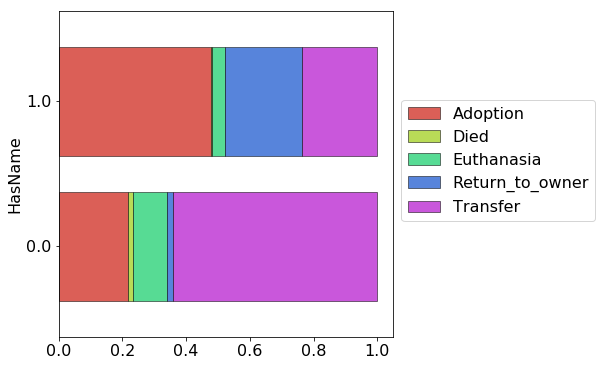

In [10]:
(animals
 .groupby("HasName")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, figsize=(6,6), width = 0.75, 
       fontsize=16, edgecolor='k', linewidth=0.5)
 .legend(fontsize=16, ncol=1, bbox_to_anchor=(1, 0.75))
)
ax = plt.gca()
ax.yaxis.label.set_size(16)

### DateTime Features
We would like to add additional features indicating timeofday, weekofyear, etc for each DateTime value

In [11]:
# we already know that "DateTime" column does not have null values
animals['Timestamps'] = pd.to_datetime(animals['DateTime'])

print "Our records are between the range {} to {}".format(animals.Timestamps.min(), animals.Timestamps.max())

Our records are between the range 2013-10-01 09:31:00 to 2016-02-21 19:17:00


In [12]:
# we convert timestamps to several potential groups
animals['Year'] = animals.Timestamps.dt.year
animals['Month'] = animals.Timestamps.dt.month
animals['Weekday'] = animals.Timestamps.dt.weekday
animals['Hour'] = animals.Timestamps.dt.hour
animals['WeekofYear'] = animals.Timestamps.dt.weekofyear
animals['DayofMonth'] = animals.Timestamps.dt.day

In [13]:
%load_ext autoreload
%autoreload 2

In [15]:
from customize_plots import plot_feature

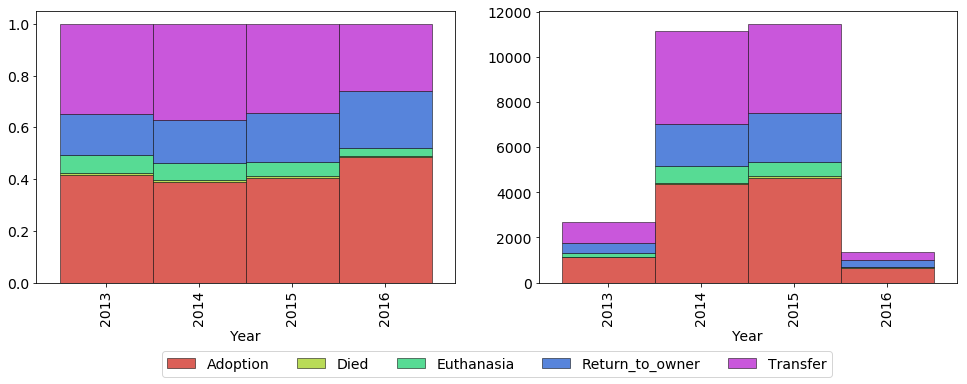

In [16]:
plot_feature("Year", data=animals)

Year does not seem to be an important feature as percentage-wise it does not affect animal outcome very much with the exception of 2016. However, since we have a lot less samples in 2016, the percentage advantage of later year is hard to infer.

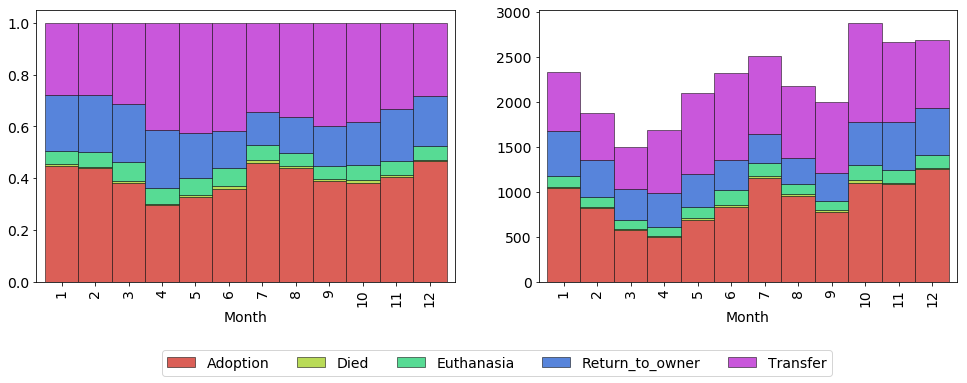

In [17]:
plot_feature("Month", data=animals)

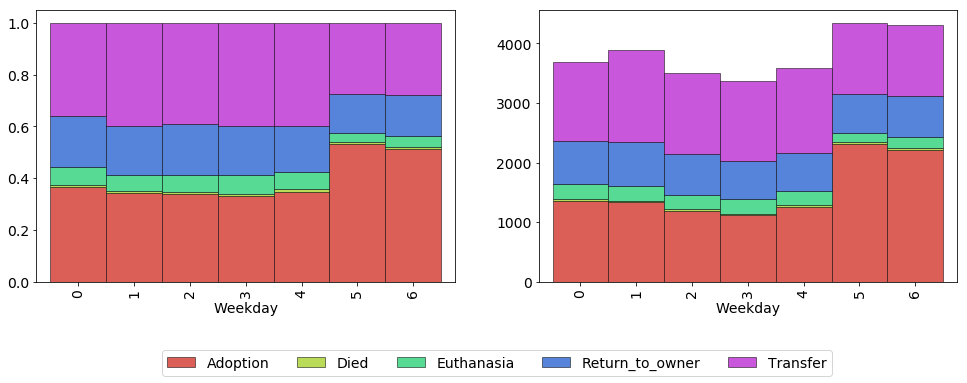

In [18]:
plot_feature("Weekday", data=animals)

Fridays and Saterdays have a higher adoption rate but lower than average transfer rate. 

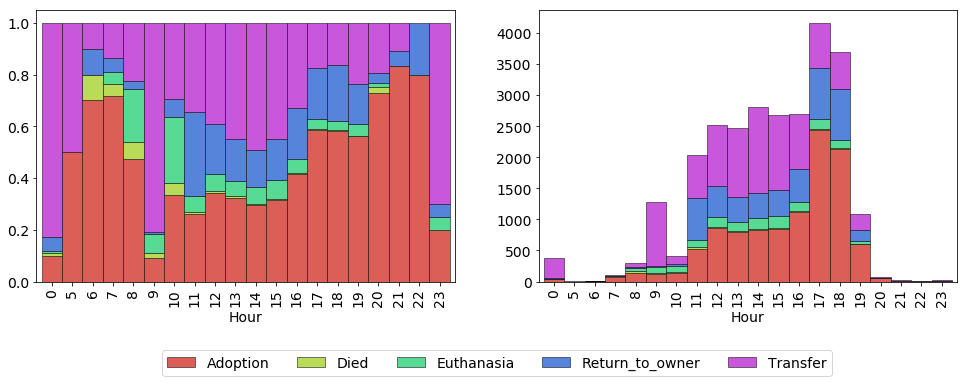

In [19]:
plot_feature("Hour", data=animals)

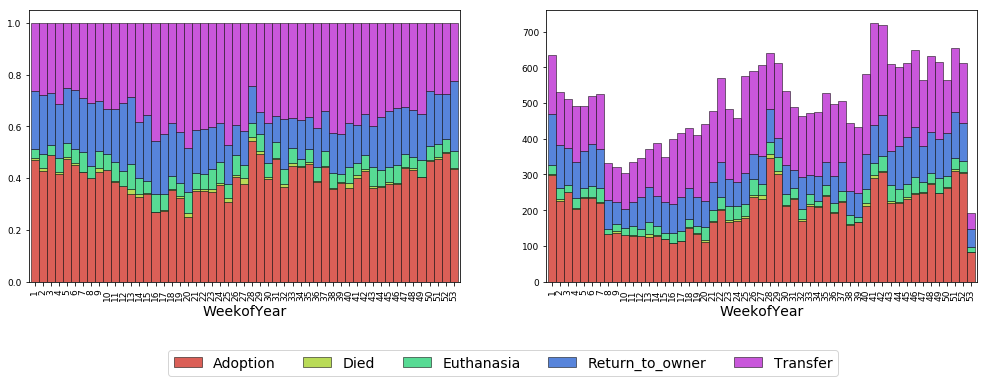

In [20]:
plot_feature("WeekofYear", data=animals, width_inches=17, tick_font_size=9)

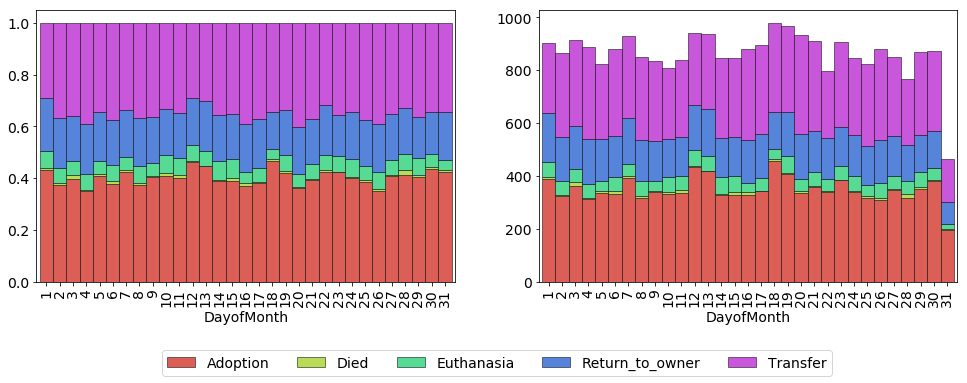

In [21]:
plot_feature('DayofMonth', data=animals)

In [22]:
# Aside from all above features, we also want to see the influnce of public holidays and holiday seasons.
# so we customized our own class "MyHolidays" based on Texas public holidays
import MyHolidays

tx_holidays = MyHolidays.MyHolidays(state="TX", years =[2015])
def is_holiday(dt):
    if (dt.month in [1,12,7,8]) or (dt.date() in tx_holidays) or dt.weekday() in [5,6]:
        return True
    return False

animals["isHoliday"] = animals.Timestamps.apply(is_holiday)
plot_feature("isHoliday", data=animals)

ImportError: No module named holidays

### AgeuponOutcome 
First we need to use the same unit on AgeuponOutcome feature. We decide to convert all of them into days. Note that some animals has an age of "0 years"

The interesting finding is that all animals are missing age info happened in a very small time window.

In [ ]:
units = {"year" : 365, "month":31, "day":1, "week":7}

def get_age_in_days(agestring):
    tokens = agestring.split(" ")
    unit = tokens[1].replace("s","")
    days = int(tokens[0]) * units[unit]
    # return days
    return days if days != 0 else -1

animals["AgeinDays"] = animals.AgeuponOutcome.map(get_age_in_days, na_action="ignore")

plot_feature('AgeinDays', animals, tick_font_size=10, title='Cats & Dogs')
plot_feature('AgeinDays', animals, filter_=animals.AnimalType=='Cat', tick_font_size=10, title='Cat')
plot_feature('AgeinDays', animals, filter_=animals.AnimalType=='Dog', tick_font_size=10, title='Dog')

In [ ]:
from plotnine import *
animals['AgeInDaysCategorical'] = pd.Categorical(animals.AgeinDays)
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    p = (ggplot(animals[animals.AgeinDays.notnull()], 
                aes(x = 'AgeInDaysCategorical', fill = 'OutcomeType'))
     + geom_bar(position = position, width=1, color='black', size=0.25)     
     + facet_grid('SexuponOutcome + HasName ~ AnimalType')
     + labs(x = 'Age In Days', y = '{} of Animals'.format(label))
     + coord_cartesian(ylim=[0, 1])
     + theme_seaborn()
     + theme(axis_text_x = element_text(angle = 90, size = 6),
             axis_text_y = element_text(size = 6),
             panel_grid_minor = element_blank(),
             legend_position = 'top',
             panel_spacing = 0.05,
             legend_title = element_blank(),
             legend_text=element_text(size=9),
             strip_text_x = element_text(size = 8),
             strip_text_y = element_text(size = 6))
    )    
    if position == 'dodge':
        p += scale_y_sqrt(breaks=(10, 200, 1000, 2000), expand = [0,0])
    else:
        p += scale_y_continuous(expand = [0,0])
    p.draw().set_size_inches(11,11)
animals.drop(['AgeInDaysCategorical'], axis=1);

In [ ]:
print "{} to {}".format(animals[animals.AgeinDays.isnull()].Timestamps.min(), 
                        animals[animals.AgeinDays.isnull()].Timestamps.max())

In [ ]:
# if we comebine them with all the AgeinDays == 0 animals, the outcome looks like this: No one was adopted
animals[(animals.AgeinDays.isnull()) | (animals.AgeinDays==-1)].OutcomeType.value_counts()
# So we decide to group nan and 0 year animals to -1

In [ ]:
# Now the distribution of ageindays looks like:
fig, ax = plt.subplots()
animals["AgeinDays"].plot(fontsize=14, kind="kde", ax=ax, xlim=(-50, 6500), secondary_y=True)
animals["AgeinDays"].plot(fontsize=14, kind="hist", bins=100, xlim=(-50, 6500),  ax=ax, zorder=2)
twin_ax = ax.figure.axes[1]
ax.yaxis.label.set_size(14)
[tick.set_fontsize(14) for tick in twin_ax.yaxis.get_ticklabels()];

We have more young animals than old. The probability distribution is greatly affected by the records (very discrete). We decide to also map ages to infant, child, young adult, adult and old groups

In [23]:
bins = [-5, 0, 5 * units["month"], 12 * units["month"], 3*units["year"],
        6 * units["year"], 10*units["year"], 20 * units["year"]]
labels = ["Unknown", "Infant", "Puppy/Kitten", "Young Adult", "Adult", "Senior", "Geriatric"]

animals["LifeStage"] = pd.Categorical(pd.cut(animals.AgeinDays, bins=bins, labels=labels), categories=labels)

NameError: name 'units' is not defined

In [ ]:
plot_feature('LifeStage', data=animals, legend_offset=-.5)

### SexuponOutcome NULL and Unknown values

In [ ]:
animals[animals.SexuponOutcome.isnull()]

In [ ]:
animals[(animals.SexuponOutcome.str.contains("Male")) & 
        (animals.AgeuponOutcome=="7 years")&
        (animals.AnimalType=="Dog") &
        (animals.OutcomeType=="Return_to_owner")
       ].SexuponOutcome.value_counts()

In [ ]:
# Given its name other info, I guess it is a male, so we narrowed down to all similar animals and 
# assign the majority sex to it.
animals.loc[3174, "SexuponOutcome"] = "Neutered Male"

As was shown before, "Unknown" sex has a disticntive distribution of outcome compared with other sex, we decide to
leave it as is. Or, we could try [different encoding schemes](http://contrib.scikit-learn.org/categorical-encoding/) and see which one works the best on our project.

So I'm planning to impute all these randomly with the top two sex within age range (0 days - 2 month) Or I should scale it idk.

In [ ]:
unknowns = animals[animals.SexuponOutcome == "Unknown"]

# so we try to see what their most shared features here
print "AnimalType Mode: ", unknowns.AnimalType.agg('mode')[0]
print "AgeinDays Median: ", unknowns.AgeinDays.median()
print "OutcomeType Mode:", unknowns.OutcomeType.mode()[0]
print "HasName Mode", unknowns.HasName.mode()[0]

These animals are mostly cats, 21 days old, no name and ended up being transfered. We pull out all records that fits this criteria:

In [ ]:
print "Total number of: ", len(unknowns)
p = animals[(animals.AnimalType=="Cat") & 
        (animals.AgeinDays<= 31) & 
        (animals.OutcomeType=="Transfer") &
        (animals.HasName==0) & 
        (animals.SexuponOutcome!="Unknown" )].SexuponOutcome.value_counts(normalize=True)
print p

So they are 53 percent intact male and 46 percent intact female. We either can use bernoulli/multinomial (if we really care) when assigning sex on these animals or leave as is.

In [ ]:
from scipy.stats import bernoulli
im_p = p["Intact Male"] 

In [ ]:
def unknown_sex(sexstring):
    if sexstring == "Unknown":
        sex = bernoulli.rvs(im_p)
        if sex == 1:
            return "Intact Male"
        else:
            return "Intact Female"
    else:
        return sexstring

In [ ]:
animals["BernoulliSex"] = animals["SexuponOutcome"].map(unknown_sex, na_action="ignore")
print "After impute distribution: "
animals.loc[animals.SexuponOutcome=="Unknown", "BernoulliSex"].value_counts(normalize=True)

While we are imputing ourselves and scikit-learn has the most basic imputer, we can also try [Orange](https://docs.orange.biolab.si/2/reference/rst/Orange.feature.imputation.html) as well. We tried but it didn't work.

### Getting Breed information

We need more information about "Breed". So we got some information from online sources [here](http://www.sorteaze.com/dog-breed-personality--social-traits.html) and [here](http://www.sorteaze.com/dog-breeds.html). Our script `load_dog_data()` is capable of scraping info from these sites from scratch. Unfortunately, this wevsite is now giving 404 error. So we are loading our backup copy.

We think dog size and their characteristics are key features when people look for dogs. However, considering lots of shelter animals were abused, their characteristic may change. Not sure if dog personalities would be important in this case, but we are keeping it for now.

In [24]:
from customize_functions import load_dog_data, load_clean_dog_data

# dog_data = load_dog_data()
dog_data_clean = load_clean_dog_data()
dog_data_clean.head()

,BreedName,Bredfor,AvgWeight(pounds),SizeScore(1to5),Intelligent,Friendliness
0,Affenpinscher,Companion,10,1,3.0,3.6
1,Afghan Hound,Tracking,55,4,2.0,2.8
2,Airedale Terrier,Retrieving,53,3,4.0,3.0
3,Akita,Hunting,105,5,2.0,2.0
4,Alaskan Klee Kai,Companion,15,2,3.0,3.2


In [ ]:
# since our record often give different names to dogs than what we downloaded online, our algorithm of matching 
# breed name search for tokens that narrows down relatable breeds instead of matching the entire breed string.
import re
import itertools
from functools import wraps
import sys

def memoize(func):
    cache = {}
    @wraps(func)
    def wrap(*args):
        if args not in cache:
            cache[args] = func(*args)
        return cache[args]
    return wrap

@memoize
def try_permutations(tokens):    
    min_count = sys.maxint
    best_string = None
    for i in range(len(tokens)):
        candidate = itertools.permutations(tokens, i+1)
        for c in candidate:
            string = ' '.join(x for x in c)            
            count = len(dog_data_clean[dog_data_clean.BreedName.str.contains(
                string, case=False)])
            if count == 1:
                return string
            if count < min_count and count != 0:
                min_count, best_string = count, string
    return best_string
            

def add_dog_data(x):
    name = x.Breed.replace(" Mix", "")
    breeds= name.split("/")
    
    matches = pd.DataFrame()
    for br in breeds:
        best_string = try_permutations(frozenset(br.split(" ")))
        if best_string:
            matches = pd.concat(
                [matches, 
                 dog_data_clean[dog_data_clean.BreedName.str.contains(
                     best_string, case=False)]
                ])
    
    return pd.Series(matches.iloc[:,1:]
                     .as_matrix()
                     .astype(int)
                     .mean(axis=0)
                     .round(0))                

animals[dog_data_clean.columns[1:]] = (animals[animals.AnimalType=='Dog']
                                 .apply(add_dog_data, axis=1))

In [ ]:
def mix_type(x):
    if 'mix' in x.lower():
        return 'Mix'
    elif '/' in x:
        return 'Cross'
    else:
        return 'Pure'

animals['MixType'] = animals["Breed"].map(mix_type)
plot_feature('MixType', data=animals)

In [ ]:
animals.loc[animals.AnimalType=="Cat", 'AvgWeight(pounds)'] = 9
animals.loc[animals.AnimalType=="Cat", 'SizeScore(1to5)'] = 1
animals.loc[animals.AnimalType=="Cat", "Intelligent"] = 3
animals.loc[animals.AnimalType=="Cat", "Friendliness"] = 3

plot_feature('SizeScore(1to5)', data=animals)
plot_feature('Intelligent', data=animals)
plot_feature('Friendliness', data=animals)

# Hair length and Color

In [ ]:
def hair(x):
    if 'Short' in str(x):
        return 'Short'
    elif 'Medium' in str(x):
        return 'Medium'
    elif 'Long' in str(x):
        return 'Long'
    else:
        return np.nan

animals['Hair'] = animals["Breed"].map(hair)
plot_feature('Hair', data=animals, legend_offset=-.4)

So far these two are not very helpful. We need to dive deeper into these features.

A lot of the color information for cats happens to be not just color but also the pattern (this also applies to dogs in some cases and others [like Merle]). A good resource for learning about cat colors and patterns is [here]( http://fixnation.org/2010/07/what-color-is-that-cat/). Using that resource let's map the colors and patterns to a smaller, more managable set.

In [ ]:
color_pattern = dict(
    Tabby='Tabby',
    Agouti='Tabby',
    Tiger='Tabby',
    Point='Point',
    Tortie='TriColor',
    Calico='TriColor',
    Torbie='TriColor',
    Brindle='TriColor',
    Smoke='Smoke',
    Merle='Merle')

color_synonym =dict(
    Flame='Orange',
    Apricot='Orange',
    Red='Red',
    Ruddy='Red',
    Gold='Yellow',
    Cream='Tan',
    Buff='Tan',
    Fawn='Tan',
    Liver='Brown',
    Seal='Brown',
    Sable='Brown',
    Chocolate='Brown',
    Blue='Grey',
    Lilac='Grey',
    goldenrod="yellow",
    darkorange="orange",
    pink="salmon", 
    peru="brown", 
    saddlebrown="brown",
    sandybrown="brown",
    yellowgreen = "yellow",
    olive="darkolivegreen",
    chocolate="brown",
    darkgray="grey",
    gainsboro="grey",
    mistyrose="salmon"
)
color = {"goldenrod": "yellow",
         "darkorange": "orange",
         "pink" : "salmon", 
         "peru" : "brown", 
         "saddlebrown" : "brown",
         "sandybrown" : "brown",
         "yellowgreen"
         "olive" : "darkolivegreen",
         "chocolate" : "brown",
         "darkgray" : "grey",
         "gainsboro" : "grey"}

main_color = [
    'Black', 
    'Brown', 
    'Yellow', 
    'Gray', 
    'Orange', 
    'Pink', 
    'Red', 
    'Silver', 
    'Tan',
    'White']

In [ ]:
def reduce_colors(color):
    result = [] 
    for c in [c.strip() for c in re.split('/| ', color)]:
        if c in main_color:
            result.append(c)
        elif c in color_synonym.keys():
            result.append(color_synonym[c])
    return 'Unknown' if not result else '/'.join(sort(list(set(result))))
    
animals['ReducedColor'] = animals.Color.map(reduce_colors)
plot_feature('ReducedColor', data=animals, tick_font_size='9', legend_offset=-0.4)

In [ ]:
print "Now we have reduced our color to {} classes.".format(len(animals.ReducedColor.unique()))

In [ ]:
# to further reduce the number of colors, we blended our colors then grouped them
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name

def memoize(func):
    cache = {}
    @wraps(func)
    def wrap(*args):
        if args not in cache:
            cache[args] = func(*args)
        return cache[args]
    return wrap
@memoize
def get_blend_color(colorstring):    
    colors = colorstring.split("/")
    pallette = array([hstack(webcolors.name_to_rgb(c)) for c in colors])
    blend = np.mean(pallette, axis=0)
    return get_colour_name(blend)

def color_name(colorstring):
    if (colorstring == "Unknown"):
        return np.nan
    cs = get_blend_color(colorstring)
    if cs in color_synonym.keys():
        return color_synonym[cs]
    return cs

In [ ]:
animals["BlendedColor"] = animals.ReducedColor.map(color_name, na_action="ignore")
print "Now we have reduced our color to {} classes.".format(len(animals.BlendedColor.unique()))

In [ ]:
plot_feature('BlendedColor', 
             data=animals,
             filter_=(animals.BlendedColor.isin(animals
                                        .BlendedColor
                                        .value_counts()
                                        .nlargest(10)
                                        .index
                                        .tolist())) & (animals.AnimalType=='Cat'),
             legend_offset=-0.5, title='Cats') 
plot_feature('BlendedColor', 
             data=animals,
             filter_=(animals.BlendedColor.isin(animals
                                        .BlendedColor
                                        .value_counts()
                                        .nlargest(10)
                                        .index
                                        .tolist())) & (animals.AnimalType=='Dog'),
             legend_offset=-0.5, title='Dogs') 

There are 22 blended colors above and the mix of dogs and cats might affect the proportions of outcomes so we are just showing the 10 most popular for cats and then dogs.

In [ ]:
def reduce_pattern(color):
    result = None
    for c in [c.strip() for c in re.split('/| ', color)]:
        if c in color_pattern.keys():
            return color_pattern[c]
    return 'BiColor' if '/' in color else 'Solid'

animals['ReducedPattern'] = animals.Color.map(reduce_pattern)

plot_feature('ReducedPattern', filter_=animals.AnimalType=='Cat', 
             title='Cats', legend_offset=-0.4)

plot_feature('ReducedPattern', filter_=animals.AnimalType=='Dog', 
             title='Dogs', legend_offset=-0.4)

## Impute Missing Value
Unfortunately, scikit-learn only has the most basic imputer that supports "mean", "median" and "mostfrequent". We found two packages that do advanced imputation algorithms. We cannot get fancyimpute up and running on the machine we use. Orange does not quite give us what we want. Although Orange3 might work, it requires python3.

In [255]:
def multinomial_impute(series, data):
    """
    :param series: a pandas.Series that is filtered to be very similar to missing values properties. 
    We count per class probability in this series.
    :param data: the original dataframe we want to impute changes on.
    return: a numpy array which has the same size as the number of null values in the series.
    """
    vc = series.value_counts(normalize=True)
    values = vc.axes[0].tolist()
    ps = vc.tolist()
    
    assert len(values) == len(ps)
    
    sample = np.random.multinomial(1, ps, size=data[series.name].isnull().sum())
    vs = array([values[i] for i in sample.argmax(axis=1)])
    # animals.loc[animals[series.name].isnull(), series.name] = vs
    data.loc[data[series.name].isnull(), series.name] = vs

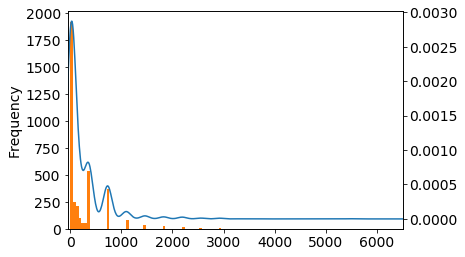

In [223]:
# as was discovered before, all animals that are missing age information are within a short time window, and 
# they are all "transfer" except two are "euthanasia". All except one are cats.
close_ages = animals[(animals.OutcomeType=="Transfer") & 
                     (animals.AnimalType=='Cat') & 
                     (animals.HasName ==0)].AgeinDays
fig, ax = plt.subplots()
close_ages.plot(fontsize=14, kind="kde", ax=ax, xlim=(-50, 6500), secondary_y=True)
close_ages.plot(fontsize=14, kind="hist", bins=100, xlim=(-50, 6500),  ax=ax, zorder=2)
twin_ax = ax.figure.axes[1]
ax.yaxis.label.set_size(14)
[tick.set_fontsize(14) for tick in twin_ax.yaxis.get_ticklabels()];

In [256]:
# Since it is likely that the missing data is the result of an randomly occured accident, 
# we think the easy approach is fitting an gaussian to it then impute for all our samples. 
multinomial_impute(close_ages, data=animals)

In [257]:
# Missing values in  "AvgWeight" "SizeScore" "Intelligent""Friendliness" are due to the fact that our database
# does not include these dog breeds. We did the same thing when imputing these values
multinomial_impute(animals.loc[animals.AnimalType=="Dog", "AvgWeight(pounds)"], data=animals)
multinomial_impute(animals.loc[animals.AnimalType=="Dog", "Intelligent"], data=animals)
multinomial_impute(animals.loc[animals.AnimalType=="Dog", "Friendliness"], data=animals)
multinomial_impute(animals.Hair, data=animals)

In [233]:
# in terms of color, all missing values had no explicit color mentioned in the original record. 
# These "colors" are represented by our pattern feature. So we give them "Not clear"
animals.loc[animals.BlendedColor.isnull(), ["AnimalType","Color", "BlendedColor"]].Color.unique()
animals.loc[animals.BlendedColor.isnull(), "BlendedColor"] = "Not_Clear"

array(['Calico', 'Torbie', 'Tricolor', 'Tortie', 'Tortie/Calico',
       'Tortie Point', 'Lynx Point', 'Calico Point',
       'Tortie Point/Lynx Point', 'Agouti', 'Calico/Tricolor',
       'Torbie/Calico', 'Tricolor/Calico'], dtype=object)

## Categorical Encoder

After all the features being extracted, we are ready to convert our categorical data into numerical data. One of the best things about the random forest model is that it **does not** require one-hot encoding for categorical data. We use [this package](http://contrib.scikit-learn.org/categorical-encoding/index.html) for categorical encoding. As one-hot increases dimension dramatically, after reading [this artical](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/), we decide to try "Binary"

In [229]:
import category_encoders as ce

In [721]:
# first we pick all cols we need to encode
col = [3] + range(10, 19) + range(20, 23) + range(24,32)

In [145]:
obj_df

NameError: name 'obj_df' is not defined

In [751]:
obj_df = animals.iloc[:, col].copy()

In [752]:
encoder = ce.BinaryEncoder(verbose=1, cols=obj_df.columns.tolist(), drop_invariant=False, return_df=True, impute_missing=True, handle_unknown="impute")

encoder.fit(obj_df, verbose=1)

data = encoder.transform(obj_df)

## Dealing with unbalanced data

In [34]:
data["Ordinal_Outcome"] = pd.Categorical(animals.OutcomeType).codes

## Start training

In [146]:
data.columns

Index([u'type_0', u'HasName_0', u'Year_0', u'Year_1', u'Month_0', u'Month_1',
       u'Month_2', u'Month_3', u'Weekday_0', u'Weekday_1', u'Weekday_2',
       u'Hour_0', u'Hour_1', u'Hour_2', u'Hour_3', u'Hour_4', u'WeekofYear_0',
       u'WeekofYear_1', u'WeekofYear_2', u'WeekofYear_3', u'WeekofYear_4',
       u'WeekofYear_5', u'DayofMonth_0', u'DayofMonth_1', u'DayofMonth_2',
       u'DayofMonth_3', u'DayofMonth_4', u'isHoliday_0', u'LifeStage_0',
       u'LifeStage_1', u'LifeStage_2', u'BernoulliSex_0', u'BernoulliSex_1',
       u'AvgWeight(pounds)_0', u'AvgWeight(pounds)_1', u'AvgWeight(pounds)_2',
       u'AvgWeight(pounds)_3', u'AvgWeight(pounds)_4', u'AvgWeight(pounds)_5',
       u'AvgWeight(pounds)_6', u'Intelligent_0', u'Intelligent_1',
       u'Intelligent_2', u'Intelligent_3', u'Intelligent_4', u'Intelligent_5',
       u'Friendliness_0', u'Friendliness_1', u'Friendliness_2',
       u'Friendliness_3', u'Friendliness_4', u'Friendliness_5', u'MixType_0',
       u'MixType_1', u'H

In [45]:
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold
SPLIT_NUM = 8

In [54]:
def run_skf(data, n_splits):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    X = data.iloc[:,3:-1]
    y = data.iloc[:,-1]
    train, test = [], []
    for train_index, test_index in skf.split(X, y):
        train.append(train_index)
        test.append(test_index)
    return train, test

In [55]:
from customize_plots import visualize_folds

In [109]:
train_total, test = train_test_split(data, test_size=.1, random_state=8)
print 'Number of samples before splitting: {}'.format(len(animals))
print 'Number of validation samples: {}'.format(len(test))
train, validation = run_skf(train_total, n_splits=SPLIT_NUM)
visualize_folds(data, train, validation)

Number of samples before splitting: 26729
Number of validation samples: 2673
Number of training samples: 21047

Training sample size per fold:


,0,1,2,3,4,Total
Fold 1,8479,150,1202,3787,7429,21047
Fold 1,8461,158,1203,3795,7430,21047
Fold 1,8494,161,1203,3734,7456,21048
Fold 1,8503,162,1205,3736,7442,21048
Fold 1,8522,153,1191,3772,7411,21049
Fold 1,8520,150,1188,3772,7421,21051
Fold 1,8505,156,1212,3773,7405,21051
Fold 1,8500,156,1200,3773,7422,21051


Validation samples per fold:


,0,2,4,1,3,Total
Fold 1,1233,170,1059,28,519,3009
Fold 1,1251,169,1058,20,511,3009
Fold 1,1218,169,1032,17,572,3008
Fold 1,1209,167,1046,16,570,3008
Fold 1,1190,181,1077,25,534,3007
Fold 1,1192,184,1067,28,534,3005
Fold 1,1207,160,1083,22,533,3005
Fold 1,1212,172,1066,22,533,3005


In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [112]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)

In [113]:
freq = data.iloc[train[0]].Ordinal_Outcome.value_counts(normalize=True, sort=False).as_matrix()

# weights = log(1./freq)
weights = 1./freq

weights = dict(enumerate(weights))

Train: 0.182389185975, Validation: 0.920987863861
Train: 0.182917640263, Validation: 0.91428733643
Train: 0.182103537692, Validation: 0.956093900592
Train: 0.182399848647, Validation: 0.860003685781
Train: 0.182874781124, Validation: 0.927532178393
Train: 0.182289807701, Validation: 0.888269792245
Train: 0.183079447271, Validation: 0.927373259066
Train: 0.182975667534, Validation: 0.891860066914
Avg Train: 0.182628739526, Avg Validation: 0.91080101041


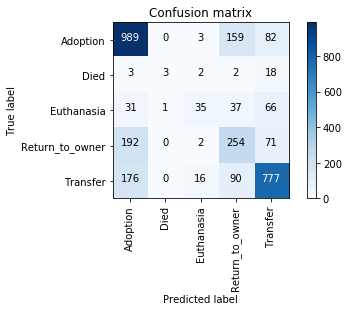

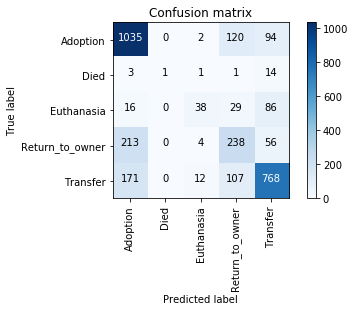

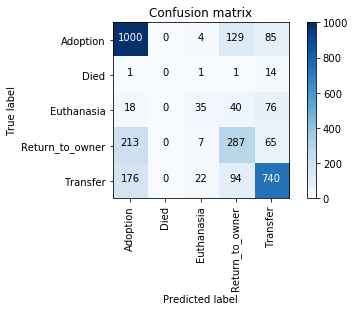

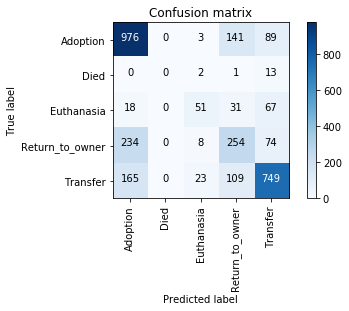

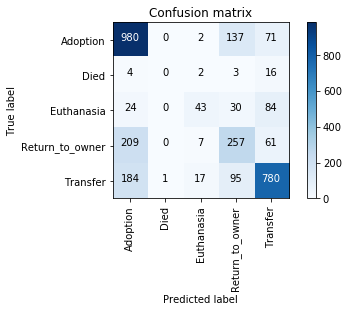

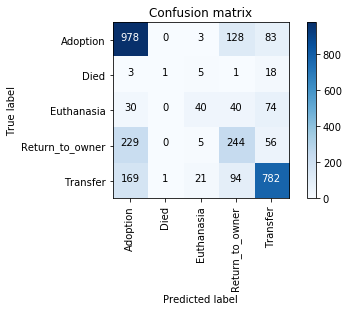

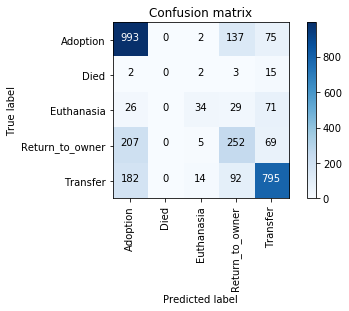

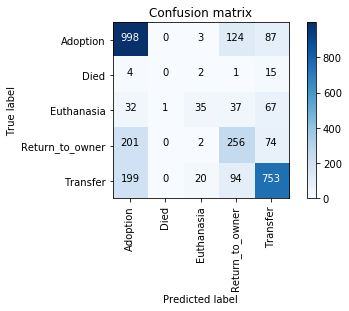

In [114]:
hard_set = set()
train_loss = 0
validation_loss = 0
for i in range(SPLIT_NUM):
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=100,
                                 random_state=8,
                                 n_jobs = 20,
                                 # class_weight=weights,
                                 max_features=None)  
    clf.fit(data.iloc[train[i], :-1], data.iloc[train[i],-1])

    pred_train = clf.predict_proba(data.iloc[train[i], :-1])
    pred_validation = clf.predict_proba(data.iloc[validation[i], :-1])
    pred_train_labels = pred_train.argmax(axis=1)
    pred_validation_labels = pred_validation.argmax(axis=1)
    train_true = pd.get_dummies(data.iloc[train[i],-1]).as_matrix()
    validation_true = pd.get_dummies(data.iloc[validation[i], -1]).as_matrix()
    

    hard_set.update(set(train[i][index] for index in where(pred_train_labels ^ data.iloc[train[i],-1])[0]))
    hard_set.update(set(validation[i][index] for index in where(pred_validation_labels ^ data.iloc[validation[i],-1])[0]))
    
    log_loss_train = log_loss(train_true, pred_train)
    log_loss_validation = log_loss(validation_true, pred_validation)
    
    train_loss += log_loss_train
    validation_loss += log_loss_validation
    
    cm = confusion_matrix(data.iloc[validation[i], -1], pred_validation.argmax(axis=1))
    plot_confusion_matrix(cm, sorted(animals.OutcomeType.unique()))
    print "Train: {}, Validation: {}".format(log_loss_train, log_loss_validation)
print "Avg Train: {}, Avg Validation: {}".format(train_loss/SPLIT_NUM, validation_loss/SPLIT_NUM)

To begin with, the classifier did poorly on Died and Euthanasia

In [115]:
hard_df = animals.iloc[list(hard_set)]

In [119]:
from scipy import interpolate 

In [143]:
interpolate.Rbf(np.hsplit(train_total[:, :-1], train_total.shape[-1]-1), function="multiquadradic")

TypeError: unhashable type